# Practical Example

In [1]:
import torch
import torchvision  # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For a nice progress bar!

C:\Users\Predator\Envs\kn_ml\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Predator\Envs\kn_ml\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from torchinfo import summary

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# Load Train Data
train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Load Test Data
test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

In [6]:
print(f'Length of Train Dataset: {len(train_dataset)}')
print(f'Length of Test Dataset: {len(test_dataset)}')

print(f'Length of Train Loader: {len(train_loader)}')
print(f'Length of Test Loader: {len(test_loader)}')

print(f'Size of Train Dataset: {train_dataset.data.size()}')
print(f'Size of Test Dataset: {test_dataset.data.size()}')

Length of Train Dataset: 60000
Length of Test Dataset: 10000
Length of Train Loader: 938
Length of Test Loader: 157
Size of Train Dataset: torch.Size([60000, 28, 28])
Size of Test Dataset: torch.Size([10000, 28, 28])


### Visualization of MNIST dataste


5


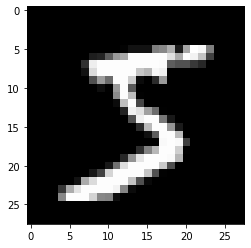

In [7]:
image, label = next(iter(train_dataset))
plt.imshow(image[0],cmap='gray')
print(label)

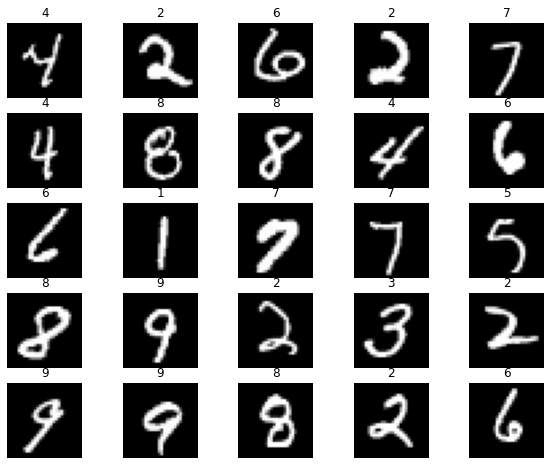

In [8]:
figure = plt.figure(figsize=(10,8))
cols, rows = 5,5
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

### Defining Recurrent Neural Network Model

In [9]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

- **input_size:** The number of expected features in the input x 
- **hidden_size:** The number of features in the hidden state h
- **num_layers:** Number of recurrent Layers: E.g: Setting num_layers = 2 would mena stacking two RNNS togther to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results
- **nonlinearity:** The non-linearity to use. Can be either `tanh` or `relu`.
- **bias**: If False, then the layer does not use bias weights b_ih and bhh.
- **batch_first:** If True, then the input and output tensors are provided as (batch, seq, feature).
- **dropout**: If non-zero, introduces a Dropout Layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout.
- **bidirectional**: If Ture, becomes a bidirectional RNN

In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    
    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Passing in the input and hidden state into the model and  obtaining outputs
        out, hidden = self.lstm(x, (h0,c0)) # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out[:, -1, :])
        return out
         
rnn = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
rnn

RNN(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [11]:
summary(rnn)

Layer (type:depth-idx)                   Param #
RNN                                      --
├─LSTM: 1-1                              212,992
├─Linear: 1-2                            1,290
Total params: 214,282
Trainable params: 214,282
Non-trainable params: 0

### Define Loss Function

In [12]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

### Define an Optimization Function

In [13]:
optimizer = optim.Adam(rnn.parameters(), lr=0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

### Train the Model

In [14]:
def train(num_epochs, model, loaders):
    total_step = len(loaders)

    for epoch in range(num_epochs):
        for i, (images,labels) in enumerate(loaders):
            
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            
            #Forward Pass
            outputs = rnn(images)
            
            #Calculating Loss
            loss = loss_func(outputs, labels)
            
            # Initializing a gradient as 0 so there is no mixing of gradient among the batches
            optimizer.zero_grad()
            
            #Propagating the error backward
            loss.backward()
            
            # Optimizing the parameters
            optimizer.step()
            
            if (i+1)%100 ==0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

In [15]:
train(num_epochs, rnn, train_loader)

Epoch [1/2], Step [100/938], Loss: 0.7312
Epoch [1/2], Step [200/938], Loss: 0.1960
Epoch [1/2], Step [300/938], Loss: 0.4182
Epoch [1/2], Step [400/938], Loss: 0.2884
Epoch [1/2], Step [500/938], Loss: 0.1302
Epoch [1/2], Step [600/938], Loss: 0.0678
Epoch [1/2], Step [700/938], Loss: 0.2296
Epoch [1/2], Step [800/938], Loss: 0.1279
Epoch [1/2], Step [900/938], Loss: 0.2739
Epoch [2/2], Step [100/938], Loss: 0.2690
Epoch [2/2], Step [200/938], Loss: 0.0308
Epoch [2/2], Step [300/938], Loss: 0.0686
Epoch [2/2], Step [400/938], Loss: 0.2259
Epoch [2/2], Step [500/938], Loss: 0.1396
Epoch [2/2], Step [600/938], Loss: 0.0279
Epoch [2/2], Step [700/938], Loss: 0.0981
Epoch [2/2], Step [800/938], Loss: 0.0500
Epoch [2/2], Step [900/938], Loss: 0.0445


### Evaluating the Model on Test Data

In [16]:
rnn.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = rnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total = total + labels.size(0)
        correct = correct + (predicted==labels).sum().item()

print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 97.55 %


### Print 10 predictions from test data

In [17]:
sample = next(iter(test_loader))
imgs, lbls = sample

imgs = imgs.to(device)
lbls = lbls.to(device)

test_output = rnn(imgs[:10].view(-1,28,28))
predicted = torch.max(test_output,1)[1]
labels = lbls[:10].cpu()
print(f'Predicted Number: {predicted}')
print(f'Actual Number: {labels}')



Predicted Number: tensor([4, 7, 0, 3, 1, 2, 5, 5, 1, 5], device='cuda:0')
Actual Number: tensor([4, 7, 0, 3, 1, 2, 5, 5, 1, 5])
